# Working with RasterIO

In this section, we will take 4 individual SRTM tiles around the Mt. Everest region and merge them to a single GeoTiff using RasterIO.
![](images/srtm.png)

In [2]:
import rasterio

In [ ]:
import os
data_pkg_path = 'data'
srtm_dir = 'srtm'
filename = 'N28E087.hgt'
path = os.path.join(data_pkg_path, srtm_dir, filename)

In [5]:
# Reading Raster Data
dataset = rasterio.open(path)
dataset.meta

{'driver': 'SRTMHGT',
 'dtype': 'int16',
 'nodata': -32768.0,
 'width': 3601,
 'height': 3601,
 'count': 1,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
 'transform': Affine(0.0002777777777777778, 0.0, 86.99986111111112,
        0.0, -0.0002777777777777778, 29.000138888888888)}

In [6]:
band1 = dataset.read(1)
print(band1)

[[5217 5211 5208 ... 5097 5098 5089]
 [5206 5201 5200 ... 5080 5075 5069]
 [5199 5194 5191 ... 5063 5055 5048]
 ...
 [5347 5345 5343 ... 5747 5750 5757]
 [5338 5338 5336 ... 5737 5740 5747]
 [5332 5331 5332 ... 5734 5736 5744]]


In [7]:
dataset.close()

## Merging Datasets

In [8]:
srtm_path = os.path.join(data_pkg_path, 'srtm')
all_files = os.listdir(srtm_path)
print(all_files)

['N27E086.hgt', 'N27E087.hgt', 'N28E086.hgt', 'N28E087.hgt']


In [9]:
dataset_list = []
for file in all_files:
    path = os.path.join(srtm_path, file)
    dataset_list.append(rasterio.open(path))
print(dataset_list)

[<open DatasetReader name='data\srtm\N27E086.hgt' mode='r'>, <open DatasetReader name='data\srtm\N27E087.hgt' mode='r'>, <open DatasetReader name='data\srtm\N28E086.hgt' mode='r'>, <open DatasetReader name='data\srtm\N28E087.hgt' mode='r'>]


In [10]:
from rasterio import merge
merged_result = merge.merge(dataset_list)
print(merged_result)

(array([[[4916, 4926, 4931, ..., 5097, 5098, 5089],
        [4919, 4932, 4928, ..., 5080, 5075, 5069],
        [4919, 4928, 4935, ..., 5063, 5055, 5048],
        ...,
        [ 368,  368,  366, ..., 1905, 1919, 1937],
        [ 364,  364,  362, ..., 1913, 1930, 1944],
        [ 360,  359,  357, ..., 1918, 1930, 1942]]], dtype=int16), Affine(0.0002777777777777778, 0.0, 85.99986111111112,
       0.0, -0.0002777777777777778, 29.000138888888888))


In [11]:
merged_data = merged_result[0]
merged_transform = merged_result[1]
merged_transform

Affine(0.0002777777777777778, 0.0, 85.99986111111112,
       0.0, -0.0002777777777777778, 29.000138888888888)

In [12]:
print(merged_data.shape)

(1, 7201, 7201)


## Writing Raster Data

In [14]:
output_filename = 'merged.tif'
output_dir = 'output'
output_path = os.path.join(output_dir, output_filename)

In [15]:
new_dataset = rasterio.open(output_path, 'w', 
                            driver='GTiff',
                            height=merged_data.shape[1],
                            width=merged_data.shape[2],
                            count=1,
                            nodata=-32768.0,
                            dtype=merged_data.dtype,
                            crs='EPSG:4326',
                            transform=merged_transform)
new_dataset.write(merged_data)
new_dataset.close()
print('Successfully written output file at {}'.format(output_path))

Successfully written output file at output\merged.tif


In [18]:
import numpy as np

# Open the raster file
with rasterio.open(output_path) as src:
    # Read the raster data into a NumPy array
    data = src.read(1)  # Read the first band, assuming single band raster

    # Get the NoData value for this raster (if it exists)
    nodata_value = src.nodata

    # If NoData exists, mask it
    if nodata_value is not None:
        data = np.ma.masked_equal(data, nodata_value)

    # Find the maximum value, ignoring NoData values
    max_value = data.max()

print(f"Maximum value in the raster: {max_value}")

Maximum value in the raster: 8748


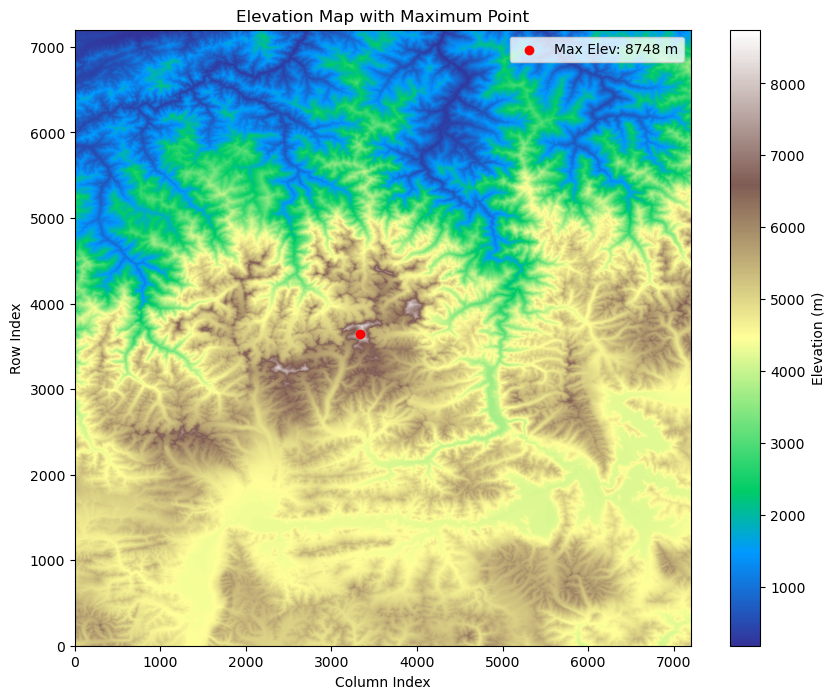

Max elevation: 8748 meters at row=3640, col=3332


<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt

# Open the raster file
with rasterio.open(output_path) as src:
    data = src.read(1)  # Read first band
    transform = src.transform

    # Get NoData and mask it if necessary
    nodata = src.nodata
    if nodata is not None:
        data = np.ma.masked_equal(data, nodata)

    # Find max value and its location (row, col)
    max_value = data.max()
    row, col = np.where(data == max_value)
    row, col = row[0], col[0]  # Get first occurrence if multiple

    # Convert row/col to real-world coordinates
    x, y = rasterio.transform.xy(transform, row, col)

# 📊 Plot the raster with the point marked
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap='terrain')
plt.colorbar(label='Elevation (m)')
plt.scatter(col, row, color='red', label=f'Max Elev: {max_value} m')
plt.legend()
plt.title("Elevation Map with Maximum Point")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.gca().invert_yaxis()  # So the origin (0,0) is top-left like raster
plt.show()

print(f"Max elevation: {max_value} meters at row={row}, col={col}")
plt.savefig('images/elevation_map_with_maxpoint.png', dpi=300, bbox_inches='tight')